# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [381]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [382]:
# Use this space for any additional import statements you need
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from emoji import UNICODE_EMOJI
import numpy as np
from nltk import FreqDist
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to C:\Users\Luis
[nltk_data]     Perez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [383]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation+ "•"+'"'+"’") # speeds up comparison
tw_punct = punctuation - {"#"}



# Stopwords
stopwords = set(stopwords.words('english'))
#sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    # Fill in the correct values here. 
    num_tokens = len([token for sublist in tokens for token in sublist])
    num_unique_tokens = len(set([token for sublist in tokens for token in sublist]))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token)for sublist in tokens for token in sublist)
    

    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    return([num_tokens, num_unique_tokens,
        lexical_diversity,
        num_characters])
    return(0)


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return([t for t in tokens if t.lower() not in stopwords])
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    
    ht = re.findall(hashtag_pattern, text)
    tokens = word_tokenize(text)
    tokens.extend(ht)
    
    return (tokens)
    #return word_tokenize(text)


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [384]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "\\Users\\Luis Perez\\Documents\\" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_follower_data.txt',
                'robyn':'robynkonichiwa_follower_data.txt'}


In [385]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [386]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [387]:
twitter_data['description'] = twitter_data['description'].fillna('')


In [389]:
# read in the lyrics here
data_location = "\\Users\\Luis Perez\\Documents\\" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_follower_data.txt',
                'robyn':'robynkonichiwa_follower_data.txt'}


In [390]:
lyrics = {}

# Define the artist names and file paths
artists = {
    'cher': '/Users/Luis Perez/Documents/lyrics/cher',
    'robyn': '/Users/Luis Perez/Documents/lyrics/robyn'
}

for artist_name, artist_path in artists.items():
    artist_lyrics = {}
    # loop over files on artist folder
    for file in os.listdir(artist_path):
        #  if lyrics file ends with .txt
        if file.endswith(".txt"):
            song_name = file.split("_")[-1].split(".")[0]
            with open(os.path.join(artist_path, file), 'r') as f:
                artist_lyrics[song_name] = f.read()
    
    lyrics[artist_name] = artist_lyrics

In [391]:
artists_clyrics_tokens = []
artists = ["cher", "robyn"]
for artist, songs in lyrics.items():
    if artist in artists:
        for song,song_list in songs.items():
            song_info = {'artist':artist, 'lyrics':song_list}
            artists_clyrics_tokens.append(song_info)
df = pd.DataFrame(artists_clyrics_tokens)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [392]:
my_pipeline = [str.lower,remove_punctuation, tokenize, remove_stop]

df["tokens"] = df["lyrics"].apply(prepare,pipeline=my_pipeline)
df["num_tokens"] = df["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

In [394]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [410]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
9979,cher,BWU ‘18 | 🌈 | writer & photographer @thehoneyp...,"[bwu, ‘, 18, 🌈, writer, photographer, thehoney..."
28575,cher,❤️🌻🎼,[❤️🌻🎼]
33707,cher,"🍯 mac n cheese milf, not a gluten free one • 🪩...","[🍯, mac, n, cheese, milf, gluten, free, one, 🪩..."
16067,cher,🧋🧋,[🧋🧋]
33970,cher,👵🏻Queen bee of the Hornet house. My tweets are...,"[👵🏻queen, bee, hornet, house, tweets, thoughts..."
29196,cher,"𝐁𝐄 𝐘𝐎𝐔𝐑𝐒𝐄𝐋𝐅, 𝐂𝐀𝐔𝐒𝐄 𝐍𝐎𝐁𝐎𝐃𝐘 𝐂𝐀𝐍 𝐃𝐎 𝐁𝐄𝐓𝐓𝐄𝐑...!!! 😊","[𝐁𝐄, 𝐘𝐎𝐔𝐑𝐒𝐄𝐋𝐅, 𝐂𝐀𝐔𝐒𝐄, 𝐍𝐎𝐁𝐎𝐃𝐘, 𝐂𝐀𝐍, 𝐃𝐎, 𝐁𝐄𝐓𝐓𝐄𝐑, 😊]"
31359,robyn,Momma x2 | #Abuelita | #Runner |#Cheesehead | ...,"[momma, x2, #, abuelita, #, runner, #, cheeseh..."
35150,cher,Blaqalleykat Productions Check Out My New Podc...,"[blaqalleykat, productions, check, new, podcas..."
1365,cher,🦝🌾🐚🌴🌊⛱️🏳️‍🌈,[🦝🌾🐚🌴🌊⛱️🏳️‍🌈]
12002,robyn,"My 3 Personality Traits are: Eurovision, Anime...","[3, personality, traits, eurovision, animemang..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area that i would like to improve if given more time is figuring out what the missing emojis are (🧋🧋) and how to capture them. Additionally, I would like to explore adding meanings to some emojis. For example, rainbow =lgbt and add it as a token and see the results. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [396]:
cher_l_tokens = df[df['artist'] == 'cher']['tokens']
robyn_l_tokens = df[df['artist'] == 'robyn']['tokens']

cher_td_tokens = twitter_data[twitter_data['artist'] == 'cher']['tokens']
robyn_td_tokens = twitter_data[twitter_data['artist'] == 'robyn']['tokens']

In [397]:
# your code here

#lyrics section
print("\nlyrics descriptions for: Cher")
assert(descriptive_stats(cher_l_tokens, verbose=True))
print("\nlyrics descriptions for: Robyn")
assert(descriptive_stats(robyn_l_tokens, verbose=True))





lyrics descriptions for: Cher
There are 36374 tokens in the data.
There are 3704 unique tokens in the data.
There are 172606 characters in the data.
The lexical diversity is 0.102 in the data.

lyrics descriptions for: Robyn
There are 15431 tokens in the data.
There are 2156 unique tokens in the data.
There are 73984 characters in the data.
The lexical diversity is 0.140 in the data.


Q: what observations do you make about these data? 

A: Both artists have plenty of words in their works, which makes them good artists to work with (on this assignment). They have simialr unique token totals and their lexical diversity is similar. Their values are what I would expect from song writers, since this medium does not require lexical dense works. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [398]:
# your code here
def get_patterns (text,num_words) :
    """ 
        This function takes text as an input and returns a dictionary of statistics,
         after cleaning the text.
    """
    if(len(text)==0):
         raise ValueError( "Can't work with empty text object.")
            
     # We '11 make things a big clearer by initializing the
     # statistics here. These are placeholder values.
    total_tokens = 1
    unique_tokens= 0
    avg_token_len= 0.0
    lex_diversity = 0.0
    top_words =[]
    
    
    if len(text)== 0:
        raise ValueError( "All of text is stopwords!")
        
     # Calculate your statistics here
    total_tokens = len([token for sublist in text for token in sublist])
    unique_tokens = len(set([token for sublist in text for token in sublist]))
    avg_token_len= np.mean([len(W) for W in text])
    lex_diversity= unique_tokens/total_tokens
    

    flattened_tokens = [token for sublist in text for token in sublist]
    top_words = FreqDist(flattened_tokens).most_common(num_words)
    #top_words = FreqDist(text).most_common(num_words)
    
    results = {'tokens': total_tokens,
                'unique_tokens':unique_tokens,
                'avg_token_length':avg_token_len,
                'lexical_diversity' :lex_diversity,
                'top_words':top_words }

    return(results)


In [399]:
get_patterns(cher_l_tokens,num_words=10)


{'tokens': 36374,
 'unique_tokens': 3704,
 'avg_token_length': 115.10759493670886,
 'lexical_diversity': 0.1018309781712212,
 'top_words': [('love', 1004),
  ('im', 513),
  ('know', 486),
  ('dont', 440),
  ('got', 352),
  ('na', 351),
  ('youre', 333),
  ('time', 319),
  ('baby', 319),
  ('see', 308)]}

In [400]:
def get_word_frac (word, fd_corpus, length):
     
    if word in fd_corpus :
         return(fd_corpus[word]/length)
    else: 
         return(0)
        
def get_ratio(word, fd_corpus_1,fd_corpus_2, len_1, len_2): 
    frac_1 = get_word_frac (word, fd_corpus_1,len_1)
    frac_2 = get_word_frac (word, fd_corpus_2,len_2)
    
    if frac_2 > 0 :
        return(frac_1/frac_2)
    else :
        return(float('Nam'))


In [401]:
def compare_texts (corpus_1, corpus_2, num_words = 10, ratio_cutoff=5):
    """
         This function returns a nested dictionary with information comparing two groups of
         text. See README for full description of what this function does.
    """
    results = dict()
    
    # Get The first two parts done with a function
    results["one"] = get_patterns(corpus_1,num_words)
    results["two"] = get_patterns(corpus_2,num_words)
    # Now we start the ratio part. Cleaning first, then build
    # frequency distributions
    #corpus_1 = token_normal(corpus_1)
    #corpus_2 = token_normal(corpus_2)
    flat_corpus_1 = [token for sublist in corpus_1 for token in sublist]
    flat_corpus_2 = [token for sublist in corpus_2 for token in sublist]
    fd_1 = FreqDist(flat_corpus_1)
    fd_2 = FreqDist(flat_corpus_2)
    #fd_1 = FreqDist(corpus_1)
    #fd_2 = Freepist(corpus_2)
    
    # It's handy to have a set of the words in each corpus.
    fd_1_words = set (fd_1.keys())
    fd_2_words = set (fd_2.keys())
    
    # This will hold *all* our ratios. Starting with 1 over 2
    holder = dict()
        
     # Also, we need to tell Python that the "one_vs_two" spot holds
     # a dictionary. (And "two_vs_one")
    results["one_vs_two"] = dict()
    results["two_vs_one"] = dict()
    
    # Now we add them. We check along the way to make sure
    for word, count in fd_1.items() :
        if count > ratio_cutoff:
             # This next line makes use of the fact that
             #Python stops evaluating "and" expressions if it hits a False
             if word in fd_2_words and fd_2[word]> ratio_cutoff:
                    holder[word] = get_ratio(word, fd_1,fd_2,
                                             results["one"]["tokens"],
                                             results["two"]["tokens"])
    num_added = 0

    for word, frac in sorted(holder.items(), key=lambda item: -1*item[1]):
        results["one_vs_two"][word] = frac
        num_added += 1
        if num_added == num_words:
            break

    # Now we do the same for two_vs_one!
    holder = dict()

    # Now we add them. We check along the way to make sure

    for word, count in fd_2.items():
        if count > ratio_cutoff:
            if word in fd_1_words and fd_1[word] > ratio_cutoff :
                holder[word] = get_ratio(word,fd_2,fd_1,
                                         results["two"]["tokens"],
                                         results["one"]["tokens"])

    num_added = 0

    for word, frac in sorted(holder.items(), key=lambda item: -1*item[1]):
        results["two_vs_one"][word] = frac
        num_added += 1
        if num_added == num_words:
            break
            
    return(results)

 


In [402]:
compare_texts(twitter_data['tokens'],df['tokens'],num_words=10)


{'one': {'tokens': 496417,
  'unique_tokens': 107503,
  'avg_token_length': 4.962581973768394,
  'lexical_diversity': 0.2165578535787453,
  'top_words': [('#', 13097),
   ('music', 3263),
   ('love', 3200),
   ('im', 3147),
   ('de', 2418),
   ('life', 2203),
   ('sheher', 2169),
   ('lover', 1806),
   ('hehim', 1768),
   ('fan', 1670)]},
 'two': {'tokens': 51805,
  'unique_tokens': 4664,
  'avg_token_length': 123.3452380952381,
  'lexical_diversity': 0.09002991989190233,
  'top_words': [('love', 1279),
   ('im', 812),
   ('know', 794),
   ('dont', 741),
   ('got', 628),
   ('baby', 541),
   ('na', 531),
   ('like', 503),
   ('youre', 502),
   ('time', 424)]},
 'one_vs_two': {'lover': 17.133657974866072,
  'en': 13.298168964513994,
  'que': 10.227067163292151,
  'family': 9.931386650067719,
  'wife': 8.583431369191626,
  '2': 7.707571025396564,
  'pop': 7.59203200132147,
  'la': 7.478977687441541,
  'food': 6.326693334434557,
  'tv': 6.144067135090055},
 'two_vs_one': {'bang': 121.8335

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I noticed that love was one of the top words for both artist which re-estates that love sells. Additionally, I noticed spanish words in the top ranks (de, en, que) tells us there is international followers ---which makes sense they are big artists. Scary that killing was among the top words in found when comparing texts. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [403]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [404]:
cher_td = twitter_data[twitter_data['artist'] == "cher"]
robyn_td = twitter_data[twitter_data['artist'] == "robyn"]

In [406]:
cher_l = df[df['artist'] == "cher"]
robyn_l = df[df['artist'] == "robyn"]

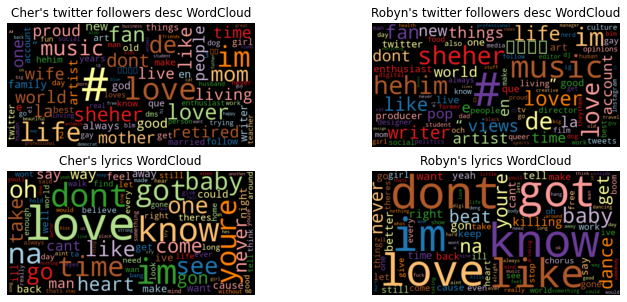

In [407]:
freq_cher_td_df = count_words(cher_td)

plt.figure(figsize=(12,5))

plt.subplot(2,2,1)###
wordcloud(freq_cher_td_df['freq'], max_words=100,
          title = "Cher's twitter followers desc WordCloud")

freq_robyn_td_df = count_words(robyn_td)
plt.subplot(2,2,2)###
wordcloud(freq_robyn_td_df['freq'],max_words=100,
          title = "Robyn's twitter followers desc WordCloud")

freq_cher_l_df = count_words(cher_l)
plt.subplot(2,2,3)###
wordcloud(freq_cher_l_df['freq'], max_words=100,
          title ="Cher's lyrics WordCloud")

freq_robyn_l_df = count_words(robyn_l)
plt.subplot(2,2,4)###
wordcloud(freq_robyn_l_df['freq'], max_words=100,
          title ="Robyn's lyrics WordCloud")

plt.show()


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: From the observations above I can see some symbols are not covered by 'punctuation', its a nice visual way to see different demographics in the artists twitter followers (he/him and she/her, they/them), I can see some words are in other languages (la, en, que), In the lyrics department we can even compare words in their case (baby, like, know). Its like a visual counterpart of the previous section "Find tokens uniquely related to a corpus".